# GSM8K pre-train vs RL evaluation visualization

Use this notebook to collect GSM8K evaluation scores from pre-training and RL runs under `/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results` and `/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results_sunny`, then plot how RL fine-tuning moves performance from its starting checkpoint.

In [86]:
from pathlib import Path
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Root locations for evaluation outputs and the metric key to read
BASE_DIRS = [
    Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results"),
    Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results_sunny"),
]
DATASET_KEY = "test_score/openai/gsm8k"

print(f"Base directories: {BASE_DIRS}")

Base directories: [PosixPath('/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results'), PosixPath('/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results_sunny')]


In [87]:
def read_score(result_path: Path, samples: int, dataset_key: str = DATASET_KEY):
    """Read score from either dict-style logs or majority-vote text.

    Returns:
        dict[int, float]: Dictionary mapping k values to scores.
                         For majority files, returns all Pass@k values found.
                         For dict-style files, returns {samples: score}.
                         Returns {} if no scores found.
    """
    if not result_path.exists():
        return {}

    text = result_path.read_text().splitlines()

    # Majority-format text file (pass@k, single-sample accuracy, etc.)
    if samples > 1 or "majority" in result_path.name:
        scores = {}
        for line in text:
            if "Pass@" in line and ":" in line:
                # Expect formats like: "  Pass@1 : 0.0403 (4.03%)" or "Pass@32 (Any Correct):  0.6884 (68.84%)"
                # Extract k value and score
                import re as _re
                # Match "Pass@<k>" pattern
                k_match = _re.search(r"Pass@(\d+)", line)
                if k_match:
                    k = int(k_match.group(1))
                    # Extract score after the colon
                    parts = line.split(":")
                    if len(parts) > 1:
                        try:
                            score = float(parts[1].split()[0])
                            scores[k] = score
                        except Exception:
                            pass
        if scores:
            return scores
        # If we didn't find Pass@, fall back to the dict parsing below

    # Dict-style log: scan from the bottom for a dict containing the key
    for line in reversed(text):
        try:
            payload = ast.literal_eval(line.strip())
        except Exception:
            continue
        if isinstance(payload, dict) and dataset_key in payload:
            return {samples: payload[dataset_key]}
    return {}

# Collect pre-train runs (pattern: 1B-step{step}-{shot}shot-{samples}samples-temp{temp})
pretrain_rows = []
pre_pattern = re.compile(r"1B-step(?P<step>\d+)-(?P<shot>\d+)shot-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")

# Collect RL runs from both naming schemes below
#   1) 1B-step{pt_step}-rl-step{rl_step}-0shot-boxed-{samples}samples-temp{temp}
#   2) olmo2_1b_step{pt_step}_omigsm8k-step{rl_step}-rl-0shot-boxed-{samples}samples-temp{temp}
#   3) olmo2_1b_step{pt_step}_omigsm8k_n{num_rollouts}-step{rl_step}-rl-...
#   4) olmo2_1b_step{pt_step}_omigsm8k_n{num_rollouts}_sunny_tmp-step{rl_step}-rl-... (Sunny's results)
rl_rows = []
rl_patterns = [
    re.compile(r"1B-step(?P<pt_step>\d+)-rl-step(?P<rl_step>\d+)-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k_n(?P<num_rollouts>\d+)-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    # Sunny's naming convention with _sunny_tmp suffix
    re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omigsm8k_n(?P<num_rollouts>\d+)_sunny_tmp-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
]

# Collect SFT runs
#   1) 1B-step{pt_step}-sft-step{sft_step}-0shot-boxed-{samples}samples-temp{temp}
#   2) OLMo2-1B-step{pt_step}-stage2-openmathgsm8k-step{sft_step}-hf-{shot}shot-{samples}samples-temp{temp}
sft_rows = []
sft_patterns = [
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-5epoch-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
    re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-10epoch-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
]

# Iterate over all base directories
for BASE_DIR in BASE_DIRS:
    if not BASE_DIR.exists():
        print(f"Warning: {BASE_DIR} does not exist, skipping...")
        continue
    
    for path in BASE_DIR.iterdir():
        if not path.is_dir():
            continue
        name = path.name

        # Pre-train collection
        pre_match = pre_pattern.match(name)
        if pre_match and not any(tag in name for tag in ["-rl-", "-sft-", "-hf"]):
            samples = int(pre_match.group("samples"))
            result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
            scores_dict = read_score(path / result_file, samples=samples)
            
            # Create a row for each k value found
            for k, score in scores_dict.items():
                pretrain_rows.append(
                    {
                        "step": int(pre_match.group("step")),
                        "shot": int(pre_match.group("shot")),
                        "samples": k,  # Use the actual k value extracted from read_score
                        "temp": float(pre_match.group("temp")),
                        "score": score,
                        "path": str(path),
                    }
                )
            continue

        # RL collection (first pattern that matches wins)
        matched = False
        for pat in rl_patterns:
            rl_match = pat.match(name)
            if rl_match:
                samples = int(rl_match.group("samples"))
                result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
                scores_dict = read_score(path / result_file, samples=samples)
                pt_step = int(rl_match.group("pt_step"))
                rl_step = int(rl_match.group("rl_step"))
                num_rollouts = int(rl_match.group("num_rollouts")) if "num_rollouts" in rl_match.groupdict() and rl_match.group("num_rollouts") else 5
                
                # Create a row for each k value found
                for k, score in scores_dict.items():
                    rl_rows.append(
                        {
                            "pt_step": pt_step,
                            "rl_step": rl_step,
                            "total_step": pt_step + rl_step,
                            "samples": k,  # Use the actual k value extracted from read_score
                            "temp": float(rl_match.group("temp")),
                            "num_rollouts": num_rollouts,
                            "score": score,
                            "path": str(path),
                            "label": name,
                        }
                    )
                matched = True
                break
        if matched:
            continue

        # SFT collection (first pattern that matches wins)
        for pat in sft_patterns:
            sft_match = pat.match(name)
            if sft_match:
                samples = int(sft_match.group("samples"))
                shot = int(sft_match.group("shot")) if "shot" in sft_match.groupdict() else None
                result_file = "gsm8k_majority_results.txt" if samples > 1 else "gsm8k_results.txt"
                scores_dict = read_score(path / result_file, samples=samples)
                pt_step = int(sft_match.group("pt_step"))
                sft_step = int(sft_match.group("sft_step"))
                # Detect epoch count from directory name
                if "10epoch" in name:
                    epochs = 10
                elif "5epoch" in name:
                    epochs = 5
                else:
                    epochs = 1
                
                # Create a row for each k value found
                for k, score in scores_dict.items():
                    sft_rows.append(
                        {
                            "pt_step": pt_step,
                            "sft_step": sft_step,
                            "total_step": pt_step + sft_step,
                            "shot": shot,
                            "samples": k,  # Use the actual k value extracted from read_score
                            "temp": float(sft_match.group("temp")),
                            "score": score,
                            "path": str(path),
                            "label": name,
                            "sft_epochs": epochs,
                        }
                    )
                break

pre_df = pd.DataFrame(pretrain_rows)
rl_df = pd.DataFrame(rl_rows)
sft_df = pd.DataFrame(sft_rows)

print(f"Loaded {len(pre_df)} pre-train runs, {len(rl_df)} RL runs, {len(sft_df)} SFT runs.")

# Remove duplicates - keep first occurrence
print(f"Removing duplicates...")
pre_df_before = len(pre_df)
rl_df_before = len(rl_df)
sft_df_before = len(sft_df)

# Only drop duplicates if dataframe is not empty
if not pre_df.empty:
    pre_df = pre_df.drop_duplicates(subset=['step', 'shot', 'samples', 'temp'], keep='first')
if not rl_df.empty:
    rl_df = rl_df.drop_duplicates(subset=['pt_step', 'rl_step', 'samples', 'temp', 'num_rollouts'], keep='first')
if not sft_df.empty:
    sft_df = sft_df.drop_duplicates(subset=['pt_step', 'sft_step', 'samples', 'temp', 'shot', 'sft_epochs'], keep='first')

print(f"Pre-train: {pre_df_before} → {len(pre_df)} ({pre_df_before - len(pre_df)} duplicates removed)")
print(f"RL: {rl_df_before} → {len(rl_df)} ({rl_df_before - len(rl_df)} duplicates removed)")
print(f"SFT: {sft_df_before} → {len(sft_df)} ({sft_df_before - len(sft_df)} duplicates removed)")

Loaded 124 pre-train runs, 192 RL runs, 89 SFT runs.
Removing duplicates...
Pre-train: 124 → 124 (0 duplicates removed)
RL: 192 → 154 (38 duplicates removed)
SFT: 89 → 89 (0 duplicates removed)


In [88]:
display(pre_df.sort_values(["step", "shot", "samples", "temp"]))
print()
display(rl_df.sort_values(["pt_step", "rl_step", "samples", "temp", "num_rollouts"]))
print()
display(sft_df.sort_values(["pt_step", "sft_step", "samples", "temp"]))



,step,shot,samples,temp,score,path
1,1000,0,1,0.6,0.015163,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
3,1000,0,8,0.6,0.081100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
2,1000,0,32,0.6,0.196400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
0,1000,0,128,0.6,0.379100,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
5,1000,1,1,0.0,0.023503,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
...,...,...,...,...,...,...
65,22000,8,1,0.0,0.172858,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
66,22000,8,1,0.6,0.140258,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
68,22000,8,8,0.6,0.462500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
67,22000,8,32,0.6,0.688400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...


,pt_step,rl_step,total_step,samples,temp,num_rollouts,score,path,label
18,1000,400,1400,1,0.6,32,0.025019,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
109,1000,400,1400,2,0.6,32,0.043500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32_sunny_tmp-step4...
110,1000,400,1400,4,0.6,32,0.070900,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32_sunny_tmp-step4...
20,1000,400,1400,8,0.6,32,0.109200,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32-step400-rl-0sho...
112,1000,400,1400,16,0.6,32,0.153500,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32_sunny_tmp-step4...
...,...,...,...,...,...,...,...,...,...
40,22000,800,22800,8,0.6,5,0.713400,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k-step800-rl-0shot-b...
45,22000,800,22800,8,0.6,32,0.724000,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step800-rl-0sh...
39,22000,800,22800,32,0.6,5,0.799800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k-step800-rl-0shot-b...
44,22000,800,22800,32,0.6,32,0.821800,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32-step800-rl-0sh...


,pt_step,sft_step,total_step,shot,samples,temp,score,path,label,sft_epochs
53,2000,2767,4767,0,1,0.6,0.1647,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
54,2000,2767,4767,0,2,0.6,0.2474,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
55,2000,2767,4767,0,4,0.6,0.3450,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
56,2000,2767,4767,0,8,0.6,0.4528,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
57,2000,2767,4767,0,16,0.6,0.5643,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
...,...,...,...,...,...,...,...,...,...,...
60,22000,2767,24767,0,2,0.6,0.5464,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-10epoc...,10
61,22000,2767,24767,0,4,0.6,0.6556,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-10epoc...,10
62,22000,2767,24767,0,8,0.6,0.7480,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-10epoc...,10
63,22000,2767,24767,0,16,0.6,0.8221,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-10epoc...,10


In [89]:
# Show RL results from sunny's eval_results_sunny directory
sunny_rl = rl_df[rl_df["path"].str.contains("eval_results_sunny")]
print(f"RL results from eval_results_sunny: {len(sunny_rl)} rows")
display(sunny_rl.sort_values(["pt_step", "rl_step", "samples", "temp"]))

RL results from eval_results_sunny: 89 rows


,pt_step,rl_step,total_step,samples,temp,num_rollouts,score,path,label
109,1000,400,1400,2,0.6,32,0.0435,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32_sunny_tmp-step4...
110,1000,400,1400,4,0.6,32,0.0709,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32_sunny_tmp-step4...
112,1000,400,1400,16,0.6,32,0.1535,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omigsm8k_n32_sunny_tmp-step4...
138,2000,400,2400,1,0.6,32,0.0904,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step2000_omigsm8k_n32_sunny_tmp-step4...
139,2000,400,2400,2,0.6,32,0.1324,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step2000_omigsm8k_n32_sunny_tmp-step4...
...,...,...,...,...,...,...,...,...,...
157,22000,600,22600,2,0.6,32,0.6140,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32_sunny_tmp-step...
158,22000,600,22600,4,0.6,32,0.6785,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32_sunny_tmp-step...
159,22000,600,22600,8,0.6,32,0.7336,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32_sunny_tmp-step...
160,22000,600,22600,16,0.6,32,0.7791,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omigsm8k_n32_sunny_tmp-step...


In [90]:
# Show RL results from sunny's eval_results_sunny directory
sunny_rl = sft_df[sft_df["path"].str.contains("eval_results_sunny")]
print(f"RL results from eval_results_sunny: {len(sunny_rl)} rows")
display(sunny_rl.sort_values(["pt_step", "samples", "temp"]))

RL results from eval_results_sunny: 48 rows


,pt_step,sft_step,total_step,shot,samples,temp,score,path,label,sft_epochs
53,2000,2767,4767,0,1,0.6,0.1647,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
54,2000,2767,4767,0,2,0.6,0.2474,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
55,2000,2767,4767,0,4,0.6,0.3450,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
56,2000,2767,4767,0,8,0.6,0.4528,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
57,2000,2767,4767,0,16,0.6,0.5643,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
58,2000,2767,4767,0,32,0.6,0.6717,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step2000-stage2-openmathgsm8k-10epoch...,10
65,3000,2767,5767,0,1,0.6,0.2199,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-10epoch...,10
66,3000,2767,5767,0,2,0.6,0.3177,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-10epoch...,10
67,3000,2767,5767,0,4,0.6,0.4220,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-10epoch...,10
68,3000,2767,5767,0,8,0.6,0.5263,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-10epoch...,10


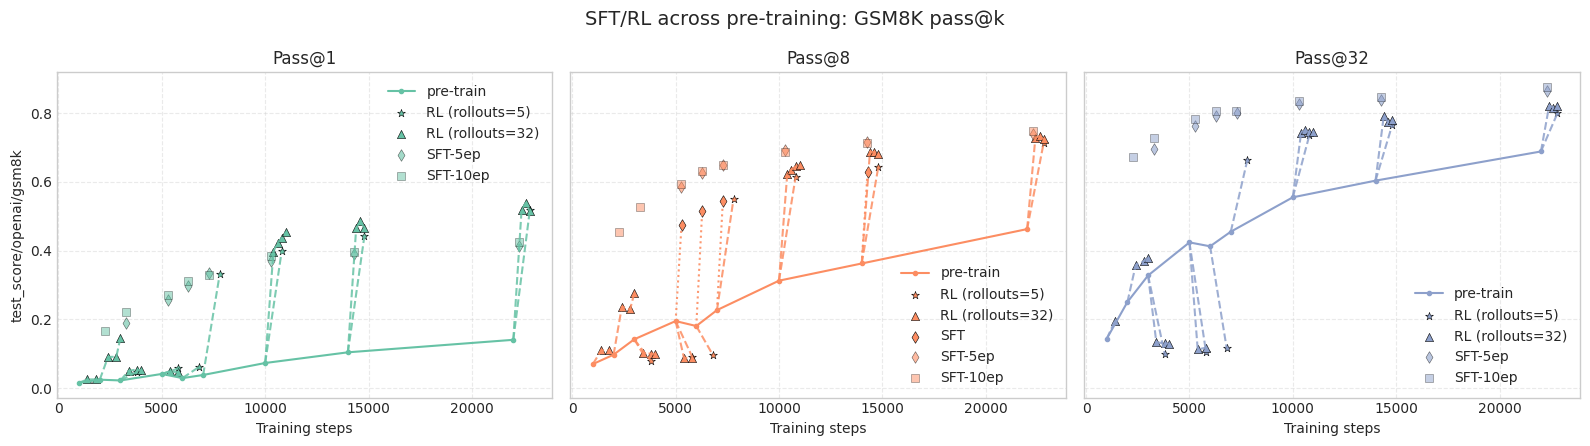

In [91]:
# Refined plotting: per-k subplots, cleaner legend markers, no RL/SFT marker at start
PLOT_SAMPLES = [1, 8, 32]
BASE_PRETRAIN_SHOT = 8
SHOT_BY_SAMPLES = lambda s: BASE_PRETRAIN_SHOT
TEMP_BY_SAMPLES = lambda s: 0.6

available_samples = sorted(set(pre_df["samples"]).union(rl_df["samples"]).union(sft_df["samples"]))
plot_samples = [s for s in PLOT_SAMPLES if s in available_samples]

plt.style.use("seaborn-v0_8-whitegrid")

if not plot_samples:
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.text(0.5, 0.5, "No runs for the selected samples/temp", transform=ax.transAxes, ha="center")
    plt.show()
else:
    n = len(plot_samples)
    ncols = n  # 2 if n > 1 else 1
    nrows = 1  # (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4.5 * nrows), sharey=True)
    axes = axes.flatten() if n > 1 else [axes]
    cmap = plt.get_cmap("Set2")

    for idx, samples in enumerate(plot_samples):
        ax = axes[idx]
        target_temp = TEMP_BY_SAMPLES(samples)
        shot = SHOT_BY_SAMPLES(samples)
        color = cmap(idx % cmap.N)

        pre_curve = pre_df[(pre_df["samples"] == samples) & (pre_df["shot"] == shot) & (pre_df["temp"] == target_temp)].sort_values("step")
        if not pre_curve.empty:
            ax.plot(pre_curve["step"], pre_curve["score"], marker=".", color=color, label="pre-train")

        # RL: plot different curves for each num_rollouts
        rl_all = rl_df[(rl_df["samples"] == samples) & (rl_df["temp"] == target_temp)].sort_values(["num_rollouts", "pt_step", "rl_step"])
        unique_num_rollouts = sorted(rl_all["num_rollouts"].dropna().unique())
        # from matplotlib.cm import get_cmap
        # rl_cmap = get_cmap("tab10")
        for j, num_rollouts in enumerate(unique_num_rollouts):
            # subcolor = rl_cmap(j % rl_cmap.N)
            subset = rl_all[rl_all["num_rollouts"] == num_rollouts]
            rl_labeled = False
            for pt_step, group in subset.groupby("pt_step"):
                pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
                start_score = pre_match.iloc[0] if not pre_match.empty else None
                group_sorted = group.sort_values("rl_step")
                xs = [pt_step] if start_score is not None else []
                ys = [start_score] if start_score is not None else []
                xs.extend((group_sorted["pt_step"] + group_sorted["rl_step"]).tolist())
                ys.extend(group_sorted["score"].tolist())
                if not xs:
                    continue
                label_rl = f"RL (rollouts={num_rollouts})" if not rl_labeled else None
                ax.plot(xs, ys, linestyle="--", marker=None, color=color, alpha=0.85)
                if len(xs) > 1:
                    ax.scatter(xs[1:], ys[1:], marker="*" if num_rollouts == 5 else "^", color=color, s=35, edgecolor="k", linewidth=0.4, label=label_rl)
                    rl_labeled = True

        # SFT standard (1 epoch)
        sft_curve = sft_df[(sft_df.get("sft_epochs", "sft") == 1) & (sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        sft_labeled = False
        for pt_step, group in sft_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("sft_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            ax.plot(xs, ys, linestyle=":", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="d", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT" if not sft_labeled else None)
                sft_labeled = True

        # SFT 5-epoch
        sft5_curve = sft_df[(sft_df.get("sft_epochs", "sft") == 5) & (sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        sft5_labeled = False
        for pt_step, group in sft5_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("sft_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
            xs = [(pt_step + (x - pt_step)//5) for x in xs]
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            # ax.plot(xs, ys, linestyle="-.", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="d", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT-5ep" if not sft5_labeled else None, alpha=0.6)
                sft5_labeled = True

        # SFT 10-epoch
        sft10_curve = sft_df[(sft_df.get("sft_epochs", "sft") == 10) & (sft_df["samples"] == samples) & (sft_df["temp"] == target_temp)].sort_values(["pt_step", "sft_step"])
        sft10_labeled = False
        for pt_step, group in sft10_curve.groupby("pt_step"):
            pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
            start_score = pre_match.iloc[0] if not pre_match.empty else None
            group_sorted = group.sort_values("sft_step")
            xs = [pt_step] if start_score is not None else []
            ys = [start_score] if start_score is not None else []
            xs.extend((group_sorted["pt_step"] + group_sorted["sft_step"]).tolist())
            xs = [(pt_step + (x - pt_step)//10) for x in xs]
            ys.extend(group_sorted["score"].tolist())
            if not xs:
                continue
            # ax.plot(xs, ys, linestyle="-.", marker=None, color=color, alpha=0.9)
            if len(xs) > 1:
                ax.scatter(xs[1:], ys[1:], marker="s", color=color, s=35, edgecolor="k", linewidth=0.4, label="SFT-10ep" if not sft10_labeled else None, alpha=0.5)
                sft10_labeled = True

        ax.set_title(f"Pass@{samples}")
        ax.set_xlabel("Training steps")
        if idx % ncols == 0:
            ax.set_ylabel(DATASET_KEY)
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.legend()

    fig.suptitle(f"SFT/RL across pre-training: GSM8K pass@k", fontsize=14)
    plt.tight_layout()
    plt.show()

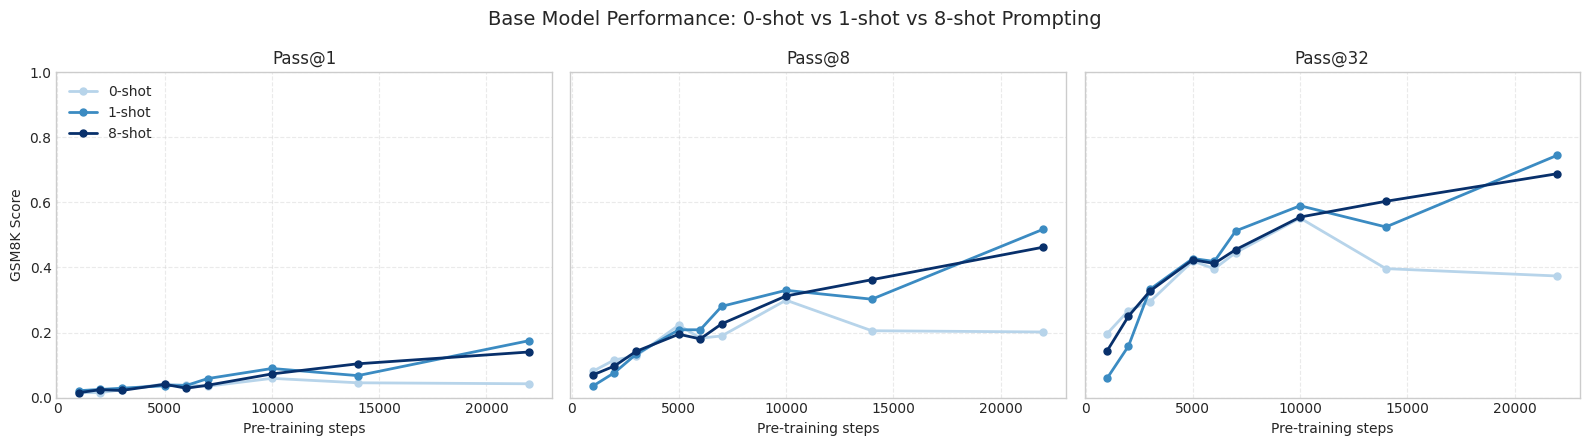

In [92]:
# Plot 1: Base model performance comparison - 0-shot vs 1-shot vs 8-shot for pass@1, pass@8, pass@32
PLOT_SAMPLES_BASE = [1, 8, 32]
SHOT_COMPARISON = [0, 1, 8]
TARGET_TEMP = 0.6

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)
cmap = plt.get_cmap("Blues")

for idx, samples in enumerate(PLOT_SAMPLES_BASE):
    ax = axes[idx]

    for shot_idx, shot in enumerate(SHOT_COMPARISON):
        # Color gradient: lighter for 0-shot, darker for 8-shot
        color = cmap(0.3 + 0.7 * shot_idx / (len(SHOT_COMPARISON) - 1))

        # Filter pre-train data for this samples/shot/temp combination
        pre_curve = pre_df[
            (pre_df["samples"] == samples) &
            (pre_df["shot"] == shot) &
            (pre_df["temp"] == TARGET_TEMP)
        ].sort_values("step")

        if not pre_curve.empty:
            ax.plot(
                pre_curve["step"],
                pre_curve["score"],
                marker="o",
                markersize=5,
                color=color,
                label=f"{shot}-shot",
                linewidth=2
            )

    ax.set_title(f"Pass@{samples}", fontsize=12)
    ax.set_xlabel("Pre-training steps")
    if idx == 0:
        ax.set_ylabel("GSM8K Score")
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left")

fig.suptitle("Base Model Performance: 0-shot vs 1-shot vs 8-shot Prompting", fontsize=14)
plt.tight_layout()
plt.show()

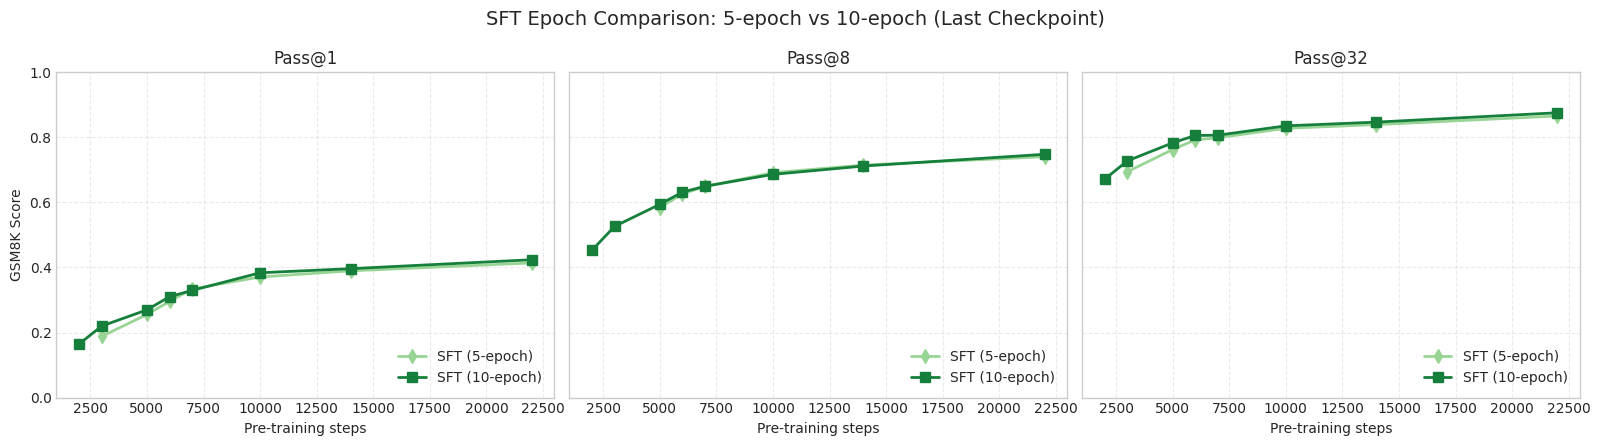

In [93]:
# Plot 2: SFT epoch comparison - 5-epoch vs 10-epoch (last checkpoint for each)
# X-axis is pt_step, different shades of green for each epoch count
PLOT_SAMPLES_BASE = [1, 8, 32]
TARGET_TEMP = 0.6
SFT_EPOCH_COMPARISON = [5, 10]

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)
green_cmap = plt.get_cmap("Greens")

for idx, samples in enumerate(PLOT_SAMPLES_BASE):
    ax = axes[idx]

    for epoch_idx, epochs in enumerate(SFT_EPOCH_COMPARISON):
        # Color gradient: lighter for 5-epoch, darker for 10-epoch
        color = green_cmap(0.4 + 0.4 * epoch_idx / (len(SFT_EPOCH_COMPARISON) - 1))

        # Filter SFT data for this samples/temp/epochs combination
        sft_subset = sft_df[
            (sft_df["samples"] == samples) &
            (sft_df["temp"] == TARGET_TEMP) &
            (sft_df["sft_epochs"] == epochs)
        ]

        # Get the last sft_step for each pt_step
        if not sft_subset.empty:
            sft_last = sft_subset.loc[sft_subset.groupby("pt_step")["sft_step"].idxmax()]
            sft_last = sft_last.sort_values("pt_step")
            ax.plot(
                sft_last["pt_step"],
                sft_last["score"],
                marker="d" if epochs == 5 else "s",
                markersize=7,
                color=color,
                label=f"SFT ({epochs}-epoch)",
                linewidth=2
            )

    ax.set_title(f"Pass@{samples}", fontsize=12)
    ax.set_xlabel("Pre-training steps")
    if idx == 0:
        ax.set_ylabel("GSM8K Score")
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend(loc="lower right")

fig.suptitle("SFT Epoch Comparison: 5-epoch vs 10-epoch (Last Checkpoint)", fontsize=14)
plt.tight_layout()
plt.show()

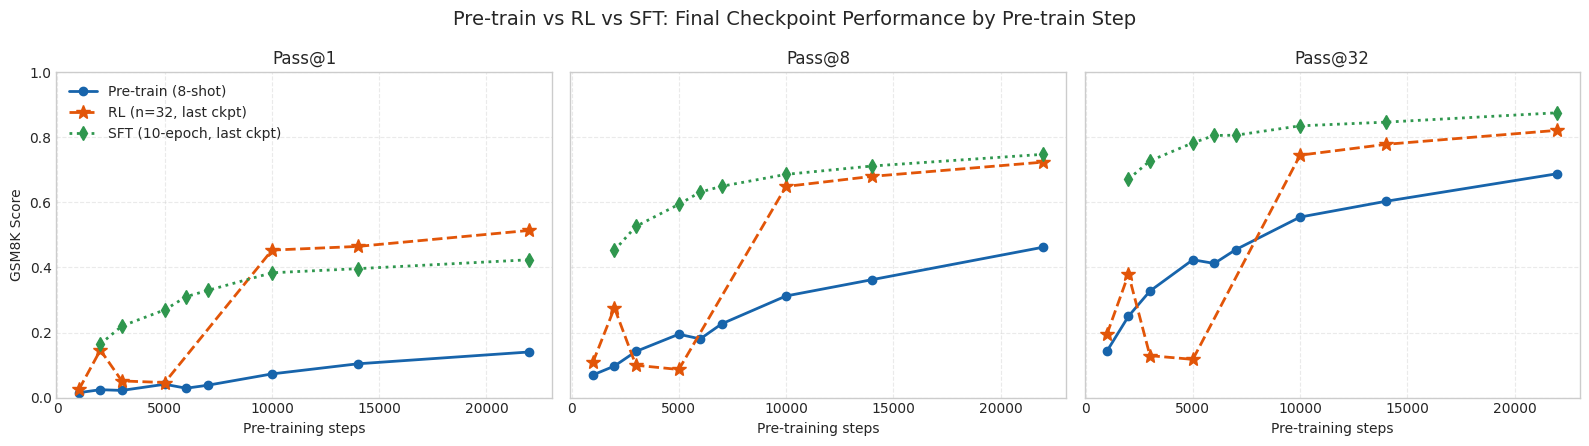

In [94]:
# Plot 3: Base model (8-shot) vs RL (rollout=32, last ckpt) vs SFT (10-epoch, last ckpt)
# X-axis is pt_step for all, different markers and colors for each method
PLOT_SAMPLES_BASE = [1, 8, 32]
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS = 32
SFT_EPOCHS = 10

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=True)

# Different color families for each method
pretrain_color = plt.get_cmap("Blues")(0.8)
rl_color = plt.get_cmap("Oranges")(0.7)
sft_color = plt.get_cmap("Greens")(0.7)

for idx, samples in enumerate(PLOT_SAMPLES_BASE):
    ax = axes[idx]

    # Pre-train (8-shot) - circle markers
    pre_curve = pre_df[
        (pre_df["samples"] == samples) &
        (pre_df["shot"] == TARGET_SHOT) &
        (pre_df["temp"] == TARGET_TEMP)
    ].sort_values("step")

    if not pre_curve.empty:
        ax.plot(
            pre_curve["step"],
            pre_curve["score"],
            marker="o",
            markersize=6,
            color=pretrain_color,
            label="Pre-train (8-shot)",
            linewidth=2
        )

    # RL (rollout=32, last checkpoint per pt_step) - star markers
    rl_subset = rl_df[
        (rl_df["samples"] == samples) &
        (rl_df["temp"] == TARGET_TEMP) &
        (rl_df["num_rollouts"] == RL_ROLLOUTS)
    ]
    # Get the last rl_step for each pt_step
    if not rl_subset.empty:
        rl_last = rl_subset.loc[rl_subset.groupby("pt_step")["rl_step"].idxmax()]
        rl_last = rl_last.sort_values("pt_step")
        ax.plot(
            rl_last["pt_step"],
            rl_last["score"],
            marker="*",
            markersize=10,
            color=rl_color,
            label=f"RL (n={RL_ROLLOUTS}, last ckpt)",
            linewidth=2,
            linestyle="--"
        )

    # SFT (10-epoch, last checkpoint per pt_step) - diamond markers
    sft_subset = sft_df[
        (sft_df["samples"] == samples) &
        (sft_df["temp"] == TARGET_TEMP) &
        (sft_df["sft_epochs"] == SFT_EPOCHS)
    ]
    # Get the last sft_step for each pt_step
    if not sft_subset.empty:
        sft_last = sft_subset.loc[sft_subset.groupby("pt_step")["sft_step"].idxmax()]
        sft_last = sft_last.sort_values("pt_step")
        ax.plot(
            sft_last["pt_step"],
            sft_last["score"],
            marker="d",
            markersize=7,
            color=sft_color,
            label=f"SFT ({SFT_EPOCHS}-epoch, last ckpt)",
            linewidth=2,
            linestyle=":"
        )

    ax.set_title(f"Pass@{samples}", fontsize=12)
    ax.set_xlabel("Pre-training steps")
    if idx == 0:
        ax.set_ylabel("GSM8K Score")
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left")

fig.suptitle("Pre-train vs RL vs SFT: Final Checkpoint Performance by Pre-train Step", fontsize=14)
plt.tight_layout()
plt.show()

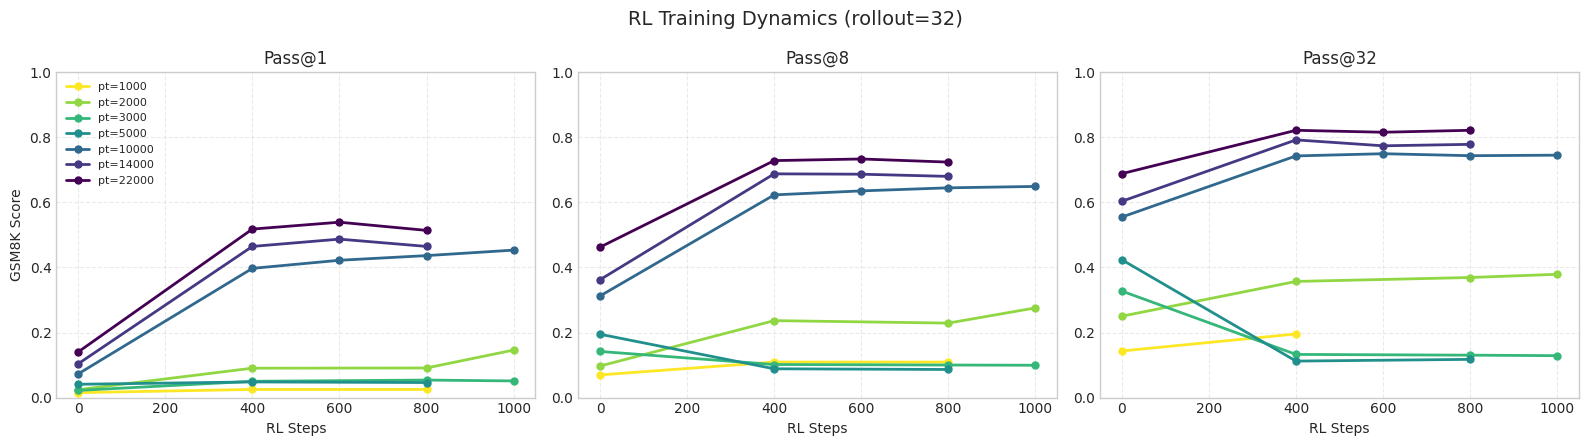

In [95]:
# Plot 4: RL training dynamics (rollout=32) - Pass@1, Pass@8, Pass@32
# X-axis is rl_step, one line per pt_step
# rl_step=0 uses the corresponding pre-train model 8-shot performance
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS = 32
PLOT_SAMPLES = [1, 8, 32]

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharey=False)
cmap = plt.get_cmap("viridis_r")

for idx, samples in enumerate(PLOT_SAMPLES):
    ax = axes[idx]

    # Filter RL data for rollout=32, this pass@k
    rl_subset = rl_df[
        (rl_df["samples"] == samples) &
        (rl_df["temp"] == TARGET_TEMP) &
        (rl_df["num_rollouts"] == RL_ROLLOUTS)
    ].sort_values(["pt_step", "rl_step"])

    # Get unique pt_steps and assign colors
    pt_steps = sorted(rl_subset["pt_step"].unique())
    n_steps = len(pt_steps)

    for i, pt_step in enumerate(pt_steps):
        color = cmap(i / (n_steps - 1) if n_steps > 1 else 0.5)
        subset = rl_subset[rl_subset["pt_step"] == pt_step].sort_values("rl_step")

        if not subset.empty:
            # Get pre-train score for rl_step=0
            pre_score = pre_df[
                (pre_df["step"] == pt_step) &
                (pre_df["samples"] == samples) &
                (pre_df["shot"] == TARGET_SHOT) &
                (pre_df["temp"] == TARGET_TEMP)
            ]
            
            # Build x and y arrays, starting with rl_step=0 if pre-train data exists
            if not pre_score.empty:
                xs = [0] + subset["rl_step"].tolist()
                ys = [pre_score.iloc[0]["score"]] + subset["score"].tolist()
            else:
                xs = subset["rl_step"].tolist()
                ys = subset["score"].tolist()

            ax.plot(
                xs,
                ys,
                marker="o",
                markersize=5,
                color=color,
                label=f"pt={pt_step}",
                linewidth=2
            )

    ax.set_title(f"Pass@{samples}", fontsize=12)
    ax.set_xlabel("RL Steps")
    if idx == 0:
        ax.set_ylabel("GSM8K Score")
    ax.set_ylim(0, 1.0)
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left", fontsize=8)

fig.suptitle(f"RL Training Dynamics (rollout={RL_ROLLOUTS})", fontsize=14)
plt.tight_layout()
plt.show()

Found pt_steps: [1000, 2000, 3000, 5000, 6000, 7000, 10000, 14000, 22000]


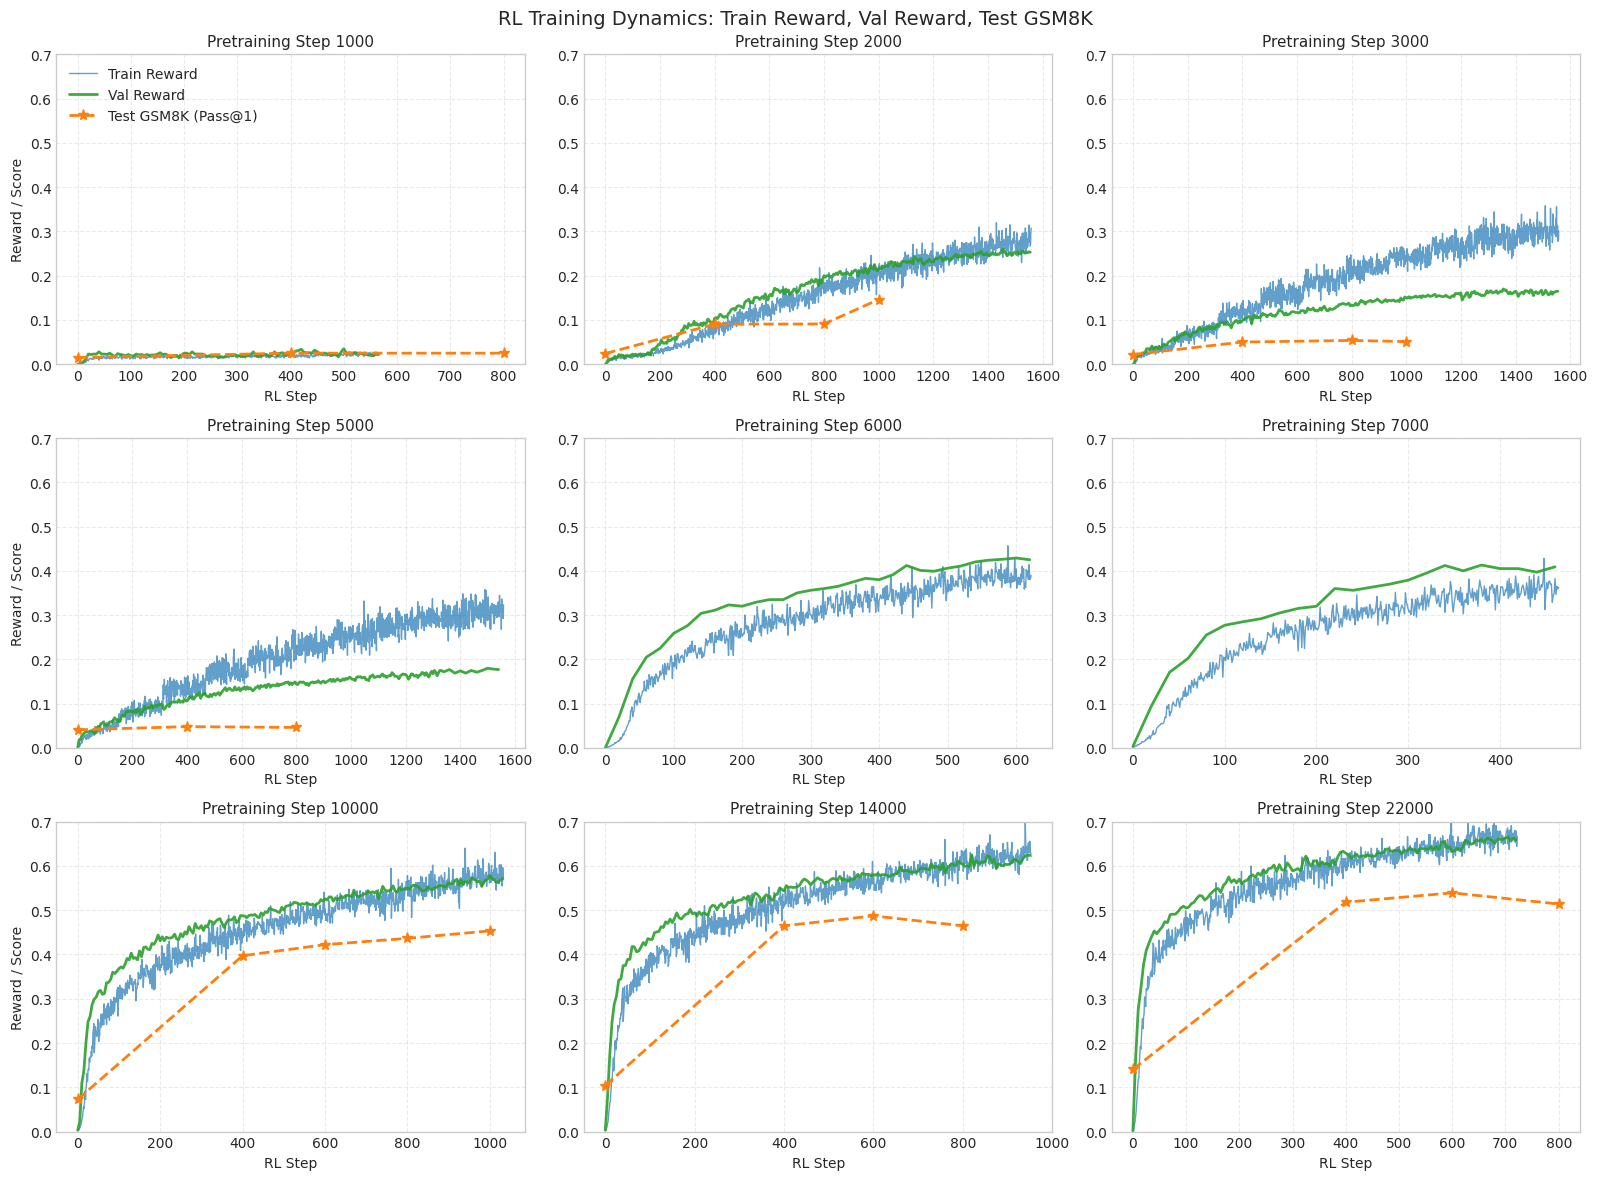

In [96]:
# Plot 5: RL Training Dynamics - 3x3 grid for each pt_step (using combined CSV files)
# Each subplot shows: (1) training reward, (2) validation reward, (3) test GSM8K performance
import os

RESULT_FILES_DIR = "/n/home05/sqin/rl_pretrain/verl/notebooks/result_files"
TRAIN_CSV = os.path.join(RESULT_FILES_DIR, "stepsall_omigsm8k_n32_train_reward.csv")
VAL_CSV = os.path.join(RESULT_FILES_DIR, "stepsall_omigsm8k_n32_val_reward.csv")
TARGET_TEMP = 0.6
TARGET_SHOT = 8
RL_ROLLOUTS = 32
TARGET_SAMPLES = 1  # pass@1 for test performance

# Load the combined CSVs
train_all_df = pd.read_csv(TRAIN_CSV)
val_all_df = pd.read_csv(VAL_CSV)

# Extract pt_steps from column headers (format: "Name: olmo2_1b_step{pt_step}_omigsm8k_n32 - ...")
def extract_pt_steps_from_columns(df, pattern=r"step(\d+)_omigsm8k"):
    pt_steps = set()
    for col in df.columns:
        match = re.search(pattern, col)
        if match:
            pt_steps.add(int(match.group(1)))
    return sorted(pt_steps)

pt_steps_from_files = extract_pt_steps_from_columns(val_all_df)
print(f"Found pt_steps: {pt_steps_from_files}")

# Create 3x3 grid
n_steps = len(pt_steps_from_files)
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12), sharey=False)
axes = axes.flatten()

for idx, pt_step in enumerate(pt_steps_from_files):
    if idx >= nrows * ncols:
        break
    ax = axes[idx]
    
    # Find columns for this pt_step
    train_col = None
    val_col = None
    for col in train_all_df.columns:
        if f"step{pt_step}_omigsm8k" in col and "__MIN" not in col and "__MAX" not in col:
            train_col = col
            break
    for col in val_all_df.columns:
        if f"step{pt_step}_omigsm8k" in col and "__MIN" not in col and "__MAX" not in col:
            val_col = col
            break
    
    # Plot training reward
    if train_col:
        train_data = train_all_df[["Step", train_col]].dropna()
        if not train_data.empty:
            ax.plot(train_data["Step"], train_data[train_col], color="tab:blue", alpha=0.7, label="Train Reward", linewidth=1)
    
    # Plot validation reward
    if val_col:
        val_data = val_all_df[["Step", val_col]].dropna()
        # Convert to numeric, coercing errors to NaN
        val_data = val_data.copy()
        val_data[val_col] = pd.to_numeric(val_data[val_col], errors='coerce')
        val_data = val_data.dropna()
        if not val_data.empty:
            ax.plot(val_data["Step"], val_data[val_col], color="tab:green", alpha=0.9, label="Val Reward", linewidth=2)
    
    # Plot test GSM8K performance (pass@1)
    rl_subset = rl_df[
        (rl_df["pt_step"] == pt_step) &
        (rl_df["samples"] == TARGET_SAMPLES) &
        (rl_df["temp"] == TARGET_TEMP) &
        (rl_df["num_rollouts"] == RL_ROLLOUTS)
    ].sort_values("rl_step")
    
    if not rl_subset.empty:
        # Get pre-train score for rl_step=0
        pre_score = pre_df[
            (pre_df["step"] == pt_step) &
            (pre_df["samples"] == TARGET_SAMPLES) &
            (pre_df["shot"] == TARGET_SHOT) &
            (pre_df["temp"] == TARGET_TEMP)
        ]
        
        if not pre_score.empty:
            test_steps = [0] + rl_subset["rl_step"].tolist()
            test_scores = [pre_score.iloc[0]["score"]] + rl_subset["score"].tolist()
        else:
            test_steps = rl_subset["rl_step"].tolist()
            test_scores = rl_subset["score"].tolist()
        
        ax.plot(test_steps, test_scores, color="tab:orange", marker="*", markersize=8, 
                label="Test GSM8K (Pass@1)", linewidth=2, linestyle="--")
    
    ax.set_title(f"Pretraining Step {pt_step}", fontsize=11)
    ax.set_xlabel("RL Step")
    if idx % ncols == 0:
        ax.set_ylabel("Reward / Score")
    ax.set_ylim(0, 0.7)
    ax.grid(True, linestyle="--", alpha=0.4)
    if idx == 0:
        ax.legend(loc="upper left", fontsize=10)

# Hide unused subplots
for idx in range(len(pt_steps_from_files), nrows * ncols):
    axes[idx].set_visible(False)

fig.suptitle("RL Training Dynamics: Train Reward, Val Reward, Test GSM8K", fontsize=14)
plt.tight_layout()
plt.show()

In [97]:
# fineweb-math for pre-training
# tiny-gsm numbers
# how back we can push the RL
# maybe we can push it way back and make up for pre-training but having to spend lot more FLOPs on RL
# poking around datasets

In [98]:
# Concise table with columns for pass@1/8/32/128 (pre, best SFT, best RL)
TARGET_KS = [1, 8, 32, 128]

rows = []
all_steps = sorted(pre_df["step"].unique().tolist())
for step in all_steps:
    row = {"pt_step": step}
    for k in TARGET_KS:
        temp = TEMP_BY_SAMPLES(k)
        shot = SHOT_BY_SAMPLES(k)

        pre_slice = pre_df[(pre_df["step"] == step) & (pre_df["samples"] == k) & (pre_df["temp"] == temp) & (pre_df["shot"] == shot)]
        row[f"pre_p{k}"] = pre_slice.iloc[-1]["score"] if not pre_slice.empty else None

        sft_slice = sft_df[(sft_df["pt_step"] == step) & (sft_df["samples"] == k) & (sft_df["temp"] == temp)]
        if not sft_slice.empty:
            best_sft = sft_slice.loc[sft_slice["total_step"].idxmax()]
            row[f"sft_p{k}"] = best_sft["score"]
            # row[f"sft_step{k}"] = best_sft["total_step"]
        else:
            row[f"sft_p{k}"] = None
            # row[f"sft_step{k}"] = None

        rl_slice = rl_df[(rl_df["pt_step"] == step) & (rl_df["samples"] == k) & (rl_df["temp"] == temp)]
        if not rl_slice.empty:
            best_rl = rl_slice.loc[rl_slice["total_step"].idxmax()]
            row[f"rl_p{k}"] = best_rl["score"]
            # row[f"rl_step{k}"] = best_rl["total_step"]
        else:
            row[f"rl_p{k}"] = None
            # row[f"rl_step{k}"] = None

    rows.append(row)

concise_df = pd.DataFrame(rows).sort_values("pt_step").reset_index(drop=True)
concise_df



,pt_step,pre_p1,sft_p1,rl_p1,pre_p8,sft_p8,rl_p8,pre_p32,sft_p32,rl_p32,pre_p128,sft_p128,rl_p128
0,1000,0.015163,NaN,0.025019,0.0697,NaN,0.1092,0.1433,NaN,0.1956,0.2828,NaN,NaN
1,2000,0.024261,0.1647,0.146100,0.0970,0.4528,0.2758,0.2502,0.6717,0.3791,0.4625,NaN,NaN
2,3000,0.021986,0.2199,0.051200,0.1418,0.5263,0.0994,0.3275,0.7278,0.1289,0.5785,0.8605,0.1084
3,5000,0.040940,0.2697,0.046247,0.1948,0.5941,0.0910,0.4238,0.7832,0.1061,0.6353,0.8893,0.1130
4,6000,0.028810,0.3103,0.061410,0.1804,0.6318,0.0963,0.4124,0.8059,0.1168,0.6732,0.9052,0.1243
5,7000,0.037908,0.3295,0.330553,0.2267,0.6497,0.5497,0.4549,0.8067,0.6634,0.6922,0.9052,0.7945
6,10000,0.072782,0.3837,0.453400,0.3124,0.6863,0.6492,0.5550,0.8355,0.7453,0.7801,0.9181,0.8249
7,14000,0.103867,0.3964,0.464746,0.3624,0.7119,0.6422,0.6035,0.8469,0.7786,0.7817,0.9265,0.8317
8,22000,0.140258,0.4238,0.514026,0.4625,0.7480,0.7134,0.6884,0.8757,0.7998,0.8469,0.9272,0.8787
